In [ ]:
from IPython.display import clear_output

In [ ]:

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

#Contents:

## We will use a dataset called MNIST. MNIST contains 60,000 images for training and 10,000 for testing.

## This notebook contains a detailed implementaiton of a NN uisng Pytorch.

1. We will explore our data.
2. We'll make a classifier for MNIST dataset in pytorch using neural network (NN) architecture


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [ ]:
train_dataset = MNIST(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
val_dataset = MNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 101853322.07it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22633724.56it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31499154.65it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6729257.78it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



#### Notice the size of the dataset

In [ ]:
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

Length of train_dataset is 60000
Length of val_dataset is 10000


In [ ]:
batch_size = 64 # To group each k samples together.

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image and its channels

The image shape: torch.Size([1, 28, 28])
Number of channels in image:  1
The image label: 5


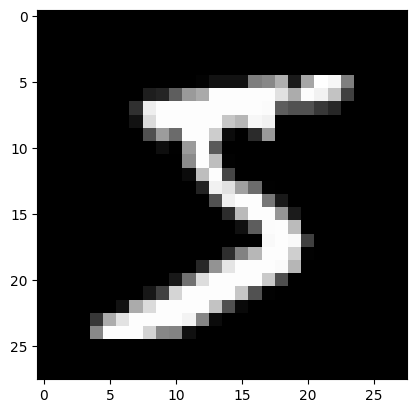

In [ ]:
random_img_idx = 0 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image shape:", image.shape)
print('Number of channels in image: ', image.shape[0]) # 1 channel (layer) for black-white images.
print("The image label:", label)

plt.imshow(image.reshape(28, 28), cmap='gray')

In [ ]:
import torch.nn.functional as F
class MyMNISTClassifier(nn.Module):
  def __init__(self, input_size):
    super(MyMNISTClassifier, self).__init__()

    # Here we decided to have 4 layers.

    # In this part, we prepare the layers.

    # First layer takes the input size (number of pixles 28 * 28 in our case)
    # The output of the layer, you can decide the size of it.
    self.linear1 = nn.Linear(input_size, 512)

    # each layer will recieve the output of the previous layer, so the input should be
    # the same size as the output from the previous layer.
    # You always decide the size of the output except in the last layer.
    self.linear2 = nn.Linear(512, 128)

    # The same as the previous one.
    self.linear3 = nn.Linear(128, 32)

    # The input has only one case.
    # You should not choose the ouput of the last layer randomly.
    # The size should be the number of labels in a classification problem. (10 labels in our case)
    self.linear4 = nn.Linear(32, 10)

  def forward(self, x):

    # In this part we connect the layer togther.

    # to start conncet the input with the first layer and then apply an activation function.
    x = torch.relu(self.linear1(x))

    # Then conncet the first layer with the second layer and then apply an activation function.
    x = torch.relu(self.linear2(x))

    # Then conncet the second layer with the third layer and then apply an activation function.
    x = torch.relu(self.linear3(x))

    # Finally, connect the third layer with the last one, and then apply sigmoid or softmax function
    # for a classificatoin problem.
    # If we are using nn.CrossEntropyLoss, we do not need to write softmax because nn.CrossEntropyLoss function computes it in one step.
    x = self.linear4(x)
    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
input_size = 28 * 28
model = MyMNISTClassifier(input_size).to(device)

In [ ]:
num_epochs = 10 # This represents how many times you want to train the model over all the data (number of iterations).
lr = 1e-3 # This is the learning rate.

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr) # Adam is an optimizer (i.e. GD, SGD)
criterion = nn.CrossEntropyLoss()  # multi-class loss.

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cuda


In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for _ in train_loader:

    # We need to flatten the input because it is a 2D array (image) not a linear.
    batch_X = batch_X.view(-1, 28 * 28)

    # Move everything to the device.
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    # predicite over X.
    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    # Compute the loss.
    loss = criterion(batch_y_probs, batch_y)

    # Reset the gradient.
    optimizer.zero_grad()

    # Compute the gradient.
    loss.backward()

    # Update the parameters.
    optimizer.step()

    # Store the loss. We just multiplied by the number of samples in the batch to use the weighted loss.
    epoch_weighted_loss += len(batch_y) * loss.item()

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0 # To count the accuracy.

  with torch.no_grad(): # To stop calculating the gradient since we do not need it here.

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.view(-1, 28 * 28)

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        # Predict on val_X
        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)

        val_epoch_weighted_loss += len(val_batch_y) * loss.item()

        # convert probailities to labels by picking the label (index) with the highest prob.
        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

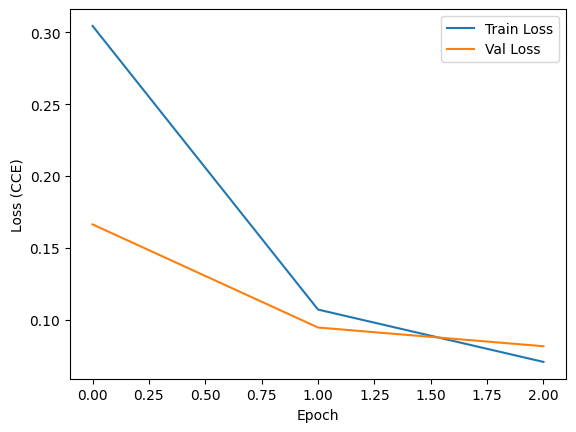

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

## Play with the model to get a better genralized model.